In [17]:
from flask import Flask, render_template, request


class Literal:
    def __init__(self, name, is_negative=False):
        self.name = name
        self.is_negative = is_negative

    def __eq__(self, other):
        return isinstance(other, Literal) and self.name == other.name and self.is_negative == other.is_negative

    def __hash__(self):
        return hash((self.name, self.is_negative))

    def __repr__(self):
        return f"¬{self.name}" if self.is_negative else self.name
    
    def __str__(self):
        return f"!{self.name}" if self.is_negative else self.name

    def contrapositive(self):
        return Literal(self.name, not self.is_negative)

class Rule:
    def __init__(self, premises, conclusion, is_defeasible, name,weight=None):
        self.premises = set(premises)  
        self.conclusion = conclusion  
        self.is_defeasible = is_defeasible
        self.name = name
        self.weight = weight

    def __eq__(self, other):
        return (isinstance(other, Rule) and self.premises == other.premises and
                self.conclusion == other.conclusion and
                self.is_defeasible == other.is_defeasible and
                self.name == other.name)

    def __hash__(self):
        return hash((frozenset(self.premises), self.conclusion, self.is_defeasible, self.name))

    def __repr__(self):
        premises_str = ', '.join(map(str, self.premises))
        arrow = "=>?" if self.is_defeasible else "=>"
        return f"{self.name}: {premises_str} {arrow} {self.conclusion}"
    

    def contrapositive_rules(self):
        # Pour une règle sans prémisse, il n'y a pas de contraposition directe.
        if not self.premises:
            return []
        # Pour les règles avec prémisses, crée des règles de contraposition.
        contrapositive_rules = []
        for premise in self.premises:
            new_premises = self.premises.difference({premise})  # Enlève la prémisse actuelle
            new_premises.add(self.conclusion.contrapositive())  # Ajoute la négation de la conclusion
            new_conclusion = premise.contrapositive()  # La nouvelle conclusion est la négation de la prémisse
            contrapositive_rules.append(Rule(new_premises, new_conclusion, self.is_defeasible, ""))
        return contrapositive_rules

class Argument:
    def __init__(self, top_rule, sub_arguments, name):
        self.top_rule = top_rule  # expects a Rule object
        self.sub_arguments = set(sub_arguments)  # expects a set of Argument objects
        self.name = name

    def __eq__(self, other):
        return isinstance(other, Argument) and self.name == other.name

    def __hash__(self):
        return hash(self.name)

    def __repr__(self):
        sub_arguments_str = ', '.join(map(str, self.sub_arguments))
        return f"{self.name}: Top rule: {self.top_rule}, Sub-arguments: {{{sub_arguments_str}}}"
    
    def textual_representation(self):
        desc = f"Argument {self.name}\n  Top Rule: {self.top_rule}\n"
        if self.sub_arguments:
            desc += "  Supports:\n    " + "\n    ".join(arg.textual_representation() for arg in self.sub_arguments)
        return desc
    
    def get_defeasible_rules(self):
        """ Return the set of all defeasible rules used in this argument and its sub-arguments. """
        defeasible_rules = set()
        if self.top_rule.is_defeasible:
            defeasible_rules.add(self.top_rule)
        for sub_arg in self.sub_arguments:
            defeasible_rules.update(sub_arg.get_defeasible_rules())
        return defeasible_rules

    def get_last_defeasible_rules(self):
        """Return the set of last defeasible rules, i.e., the defeasible rules not used in sub-arguments of this argument."""
        if not self.sub_arguments:  # If there are no sub-arguments, return the top rule if it is defeasible
            return {self.top_rule} if self.top_rule.is_defeasible else set()

        last_defeasible_rules = self.get_defeasible_rules()  # Start with all defeasible rules

        # Remove the defeasible rules that are in sub-arguments
        for sub_arg in self.sub_arguments:
            last_defeasible_rules.difference_update(sub_arg.get_defeasible_rules())

        return last_defeasible_rules

    def get_all_sub_arguments(self):
        """ Return the set of all sub-arguments of this argument, including nested ones. """
        all_sub_args = set(self.sub_arguments)
        for sub_arg in self.sub_arguments:
            all_sub_args.update(sub_arg.get_all_sub_arguments())
        return all_sub_args

In [18]:
#Step 1

# First, create rule r4 since it needs to be referenced by name in rule r9
r4 = Rule([Literal('a')], Literal('d', True), True, 'r4',weight=0)

# Définir les règles strictes fournies
strict_rules = [
    Rule([], Literal('a'), False, 'r1'),
    Rule([Literal('b'), Literal('d')], Literal('c'), False, 'r2'),
    Rule([Literal('c', True)], Literal('d'), False, 'r3')
]

# Define the remaining defeasible rules, referencing 'r4' by its name in 'r9'
defeasible_rules = [
    r4,
    Rule([], Literal('b'), True, 'r5',weight=1),
    Rule([], Literal('c', True), True, 'r6',weight=1),
    Rule([], Literal('d'), True, 'r7',weight=0),
    Rule([Literal('c')], Literal('e'), True, 'r8',weight=0),
    Rule([Literal('c', True)], Literal(r4.name, True), True, 'r9',weight=0)
]
# Générer les contrapositions pour les règles strictes spécifiées
contrapositions = []
for rule in strict_rules:
    contrapositions.extend(rule.contrapositive_rules())

# Assigner les noms spécifiques r10, r11, r12 aux contrapositions
for i, rule in enumerate(contrapositions, start=10):
    rule.name = f"r{i}"

# Afficher les règles strictes et leurs contrapositions
print("---- Strict Rules and their Contrapositions ----")
for rule in strict_rules + contrapositions:
    print(f"{rule.name}: {', '.join(str(p) for p in rule.premises)} -> {rule.conclusion}")

    # Afficher les règles défaisables
print("\n---- Defeasible Rules ----")
for rule in defeasible_rules:
    weight = rule.weight if rule.weight is not None else 'None'
    print(f"{rule.name}: {', '.join(str(p) for p in rule.premises)} => {rule.conclusion} {weight}")


def parse_rules(input_text):
    rules = []
    lines = input_text.strip().split('\n')
    for line in lines:
        line = line.strip()
        if not line:
            continue

        # Extracting the rule name and body
        parts = line.split(':')
        if len(parts) < 2:
            continue  # Skip malformed lines
        rule_name = parts[0].strip()
        rule_body = parts[1].strip()

        # Determining defeasibility and splitting premises and conclusion
        is_defeasible = '=>' in rule_body
        split_char = '=>' if is_defeasible else '->'
        premises_part, conclusion_part = rule_body.split(split_char)
        premises = [parse_literal(p.strip()) for p in premises_part.split(',') if p.strip()]
        conclusion = parse_literal(conclusion_part.strip())

        rules.append(Rule(premises, conclusion, is_defeasible, rule_name))
    return rules

def parse_literal(literal_str):
    is_negative = literal_str.startswith('!')
    name = literal_str[1:] if is_negative else literal_str
    return Literal(name, is_negative)


---- Strict Rules and their Contrapositions ----
r1:  -> a
r2: b, d -> c
r3: !c -> d
r10: !c, d -> !b
r11: !c, b -> !d
r12: !d -> c

---- Defeasible Rules ----
r4: a => !d 0
r5:  => b 1
r6:  => !c 1
r7:  => d 0
r8: c => e 0
r9: !c => !r4 0


In [19]:
import itertools
  
def generate_arguments(rules):
    # Starting with an empty list for arguments
    arguments = []
    # A dictionary to map rules to their generated arguments
    rule_to_argument = {}

    def create_argument_if_new(rule, sub_arguments):
    # Create a unique key for the rule and its sub-arguments
        unique_key = (rule, frozenset(sub_arguments))
    
    # Check if we already have this argument
        if unique_key not in rule_to_argument:
        # Create the argument and store it in both the list and the dictionary
            argument = Argument(rule, sub_arguments, f"A{len(arguments) + 1}")
            arguments.append(argument)
            rule_to_argument[unique_key] = argument
            return True
        return False

    # Generate base arguments from rules with no premises
    for rule in rules:
        if not rule.premises:
            create_argument_if_new(rule, [])

    # Generate sub-arguments for rules with premises
    def get_sub_arguments(premise, existing_arguments):
        return [arg for arg in existing_arguments if arg.top_rule.conclusion == premise]

    # Keep generating arguments until no new ones can be created
    new_arguments_added = True
    while new_arguments_added:
        new_arguments_added = False
        # Now we iterate through the rules to generate arguments with sub-arguments
        for rule in rules:
            # Skip rules without premises since we've already handled them
            if rule.premises:
                all_sub_argument_combinations = itertools.product(
                    *[get_sub_arguments(premise, arguments) for premise in rule.premises]
                )
                for sub_argument_combination in all_sub_argument_combinations:
                    if create_argument_if_new(rule, sub_argument_combination):
                        new_arguments_added = True

    return arguments

# We assume that strict_rules, defeasible_rules, and contrapositions are already defined lists of Rule objects.
combined_rules = strict_rules + defeasible_rules + contrapositions
all_arguments = generate_arguments(combined_rules)

# Print the arguments
for arg in all_arguments:
    premises = ', '.join(sub_arg.name for sub_arg in arg.sub_arguments)
    arrow = "=>?" if arg.top_rule.is_defeasible else "=>"
    print(f"{arg.name}: {premises} {arrow} {arg.top_rule.conclusion}")




for arg in all_arguments:
    defeasible_rules = arg.get_defeasible_rules()
    last_defeasible_rules = arg.get_last_defeasible_rules()
    all_sub_args = arg.get_all_sub_arguments()

    # Format the sets for printing
    defeasible_rules_str = ', '.join(rule.name for rule in defeasible_rules)
    last_defeasible_rules_str = ' '.join(rule.name for rule in last_defeasible_rules)
    all_sub_args_str = ', '.join(sub_arg.name for sub_arg in all_sub_args)


    # Print the details
    print(f" {arg.name}: Defeasible rule: {defeasible_rules_str}, Last Defeasible: {last_defeasible_rules_str}, Sub-Arguments: {all_sub_args_str}")

A1:  => a
A2:  =>? b
A3:  =>? !c
A4:  =>? d
A5: A4, A2 => c
A6: A3 => d
A7: A1 =>? !d
A8: A5 =>? e
A9: A3 =>? !r4
A10: A3, A4 => !b
A11: A3, A6 => !b
A12: A3, A2 => !d
A13: A7 => c
A14: A12 => c
A15: A6, A2 => c
A16: A13 =>? e
A17: A14 =>? e
A18: A15 =>? e
 A1: Defeasible rule: , Last Defeasible: , Sub-Arguments: 
 A2: Defeasible rule: r5, Last Defeasible: r5, Sub-Arguments: 
 A3: Defeasible rule: r6, Last Defeasible: r6, Sub-Arguments: 
 A4: Defeasible rule: r7, Last Defeasible: r7, Sub-Arguments: 
 A5: Defeasible rule: r5, r7, Last Defeasible: , Sub-Arguments: A4, A2
 A6: Defeasible rule: r6, Last Defeasible: , Sub-Arguments: A3
 A7: Defeasible rule: r4, Last Defeasible: r4, Sub-Arguments: A1
 A8: Defeasible rule: r8, r7, r5, Last Defeasible: r8, Sub-Arguments: A5, A4, A2
 A9: Defeasible rule: r9, r6, Last Defeasible: r9, Sub-Arguments: A3
 A10: Defeasible rule: r7, r6, Last Defeasible: , Sub-Arguments: A3, A4
 A11: Defeasible rule: r6, Last Defeasible: , Sub-Arguments: A3, A6
 A12: 

In [20]:
#Step 3 Generating attacks 
def generate_all_undercut(arguments):
    under = []
    for arg1 in arguments:
        for arg2 in arguments:
            # Check if arg2 is a sub-argument of arg1
            sub_arguments = arg2.get_defeasible_rules()
            arg1_conclusion = arg1.top_rule.conclusion
            arg1_conclusion_contrapositive = arg1.top_rule.conclusion.contrapositive()
            for sub_arg in sub_arguments:
                if (
                    arg2.top_rule.conclusion != arg1_conclusion_contrapositive and
                    arg1_conclusion.name == sub_arg.name 
                    #supprime A9 undercuts A13
                    #arg2.top_rule.is_defeasible and
                ):
                    under.append((arg1, arg2))
    return under

# Assuming all_arguments is populated with Argument instances
undercuts = generate_all_undercut(all_arguments)

# Print the undercuts
for undercut in undercuts:
    print(f"{undercut[0].name} undercuts {undercut[1].name}")


def generate_all_rebuts(arguments):
    # Dictionary to store arguments by their conclusion literals for easy access
    conclusion_to_arguments = {}
    rebuts = []

    # Populate the dictionary with arguments and sub-arguments keyed by their conclusion literal
    for arg in arguments:
        populate_conclusion_dictionary(arg, conclusion_to_arguments)

    # Check for rebuts by comparing each argument and its sub-arguments against possible contrapositives in the dictionary
    for arg in arguments:
        checked_pairs = set()  # To avoid checking the same pair multiple times
        check_and_add_rebuts_recursively(arg, conclusion_to_arguments, rebuts, checked_pairs)

    return rebuts

def populate_conclusion_dictionary(arg, dictionary):
    """ Recursively add all conclusions of an argument and its sub-arguments to the dictionary. """
    conclusion_literal = str(arg.top_rule.conclusion)
    if conclusion_literal not in dictionary:
        dictionary[conclusion_literal] = []
    if arg not in dictionary[conclusion_literal]:
        dictionary[conclusion_literal].append(arg)
    for sub_arg in arg.sub_arguments:
        populate_conclusion_dictionary(sub_arg, dictionary)

def check_and_add_rebuts_recursively(arg, dictionary, rebuts, checked_pairs):
    """ Recursively check and add rebuts, including all nested sub-arguments. """
    for sub_arg in arg.sub_arguments:
        check_and_add_rebuts_recursively(sub_arg, dictionary, rebuts, checked_pairs)

    # Check if the argument or any of its sub-arguments can rebut others
    find_rebuts_for_arg_and_subargs(arg, dictionary, rebuts, checked_pairs)

def find_rebuts_for_arg_and_subargs(arg, dictionary, rebuts, checked_pairs):
    """ Check for rebuts for an argument and recursively for its sub-arguments. """
    contrapositive_conclusion = str(arg.top_rule.conclusion.contrapositive())
    if contrapositive_conclusion in dictionary:
        for rebutting_arg in dictionary[contrapositive_conclusion]:
            pair = (arg, rebutting_arg)
            if arg != rebutting_arg and not is_sub_argument(rebutting_arg, arg) and pair not in checked_pairs:
                rebuts.append(pair)
                checked_pairs.add(pair)  # Mark this pair as checked

def is_sub_argument(possible_sub, main_arg):
    """ Check if possible_sub is a sub-argument of main_arg recursively. """
    if possible_sub in main_arg.sub_arguments:
        return True
    for sub_arg in main_arg.sub_arguments:
        if is_sub_argument(possible_sub, sub_arg):
            return True
    return False


all_rebuts = generate_all_rebuts(all_arguments)
print(f"Total rebuts found: {len(all_rebuts)}")
for (arg1, arg2) in all_rebuts:
    print(f"{arg1.name} rebuts {arg2.name}")


A9 undercuts A7
A9 undercuts A13
A9 undercuts A16
Total rebuts found: 90
A2 rebuts A10
A2 rebuts A11
A3 rebuts A5
A3 rebuts A13
A3 rebuts A14
A3 rebuts A15
A4 rebuts A7
A4 rebuts A12
A4 rebuts A7
A4 rebuts A12
A2 rebuts A10
A2 rebuts A11
A5 rebuts A3
A3 rebuts A5
A3 rebuts A13
A3 rebuts A14
A3 rebuts A15
A6 rebuts A7
A6 rebuts A12
A7 rebuts A4
A7 rebuts A6
A4 rebuts A7
A4 rebuts A12
A2 rebuts A10
A2 rebuts A11
A5 rebuts A3
A3 rebuts A5
A3 rebuts A13
A3 rebuts A14
A3 rebuts A15
A3 rebuts A5
A3 rebuts A13
A3 rebuts A14
A3 rebuts A15
A4 rebuts A7
A4 rebuts A12
A10 rebuts A2
A3 rebuts A5
A3 rebuts A13
A3 rebuts A14
A3 rebuts A15
A6 rebuts A7
A6 rebuts A12
A11 rebuts A2
A3 rebuts A5
A3 rebuts A13
A3 rebuts A14
A3 rebuts A15
A2 rebuts A10
A2 rebuts A11
A12 rebuts A4
A12 rebuts A6
A7 rebuts A4
A7 rebuts A6
A13 rebuts A3
A3 rebuts A5
A3 rebuts A13
A3 rebuts A14
A3 rebuts A15
A2 rebuts A10
A2 rebuts A11
A12 rebuts A4
A12 rebuts A6
A3 rebuts A5
A3 rebuts A13
A3 rebuts A14
A3 rebuts A15
A6 rebuts

In [21]:
#Step 4 :

# Example rules with weights
rules = [
    Rule([], "a", True, 'r_4', weight=5),  # Higher weight for higher preference
    Rule([], "f", True, 'r_6', weight=5),  # Same high weight as r_4
    Rule([], "b", True, 'r_2', weight=1),
    Rule([], "c", True, 'r_7', weight=1),
    Rule([], "d", True, 'r_8', weight=1),
    Rule([], "e", True, 'r_9', weight=1)
]
# Dictionary mapping rule names to Rule objects for easy access
rule_dict = {rule.name: rule for rule in rules}

def get_rule_by_name(name):
    return rule_dict.get(name)

def is_preferred(over, under):
    """ Check if rule 'over' is preferred over rule 'under' by comparing their weights. """
    rule_over = get_rule_by_name(over)
    rule_under = get_rule_by_name(under)
    if rule_over and rule_under:
        return rule_over.weight > rule_under.weight
    return False

# Testing for the preferences based on weights
print("Is r_4 preferred over r_7?", is_preferred('r_4', 'r_7'))
print("Is r_6 preferred over r_2?", is_preferred('r_6', 'r_2'))
print("Is r_2 preferred over r_4?", is_preferred('r_2', 'r_4'))

def compare_arguments(arg1, arg2, principle):
    mode, link = principle

    # Extract strengths based on the link principle
    strength1 = get_argument_strength(arg1, link)
    strength2 = get_argument_strength(arg2, link)

    # Apply mode principle
    if mode == 'elitist':
        if strength1 > strength2:
            return 'arg1'
        elif strength2 > strength1:
            return 'arg2'
        else:
            return 'equal'
    elif mode == 'democratic':
        total_strength1 = sum(get_argument_strength(sub_arg, link) for sub_arg in arg1.get_all_sub_arguments())
        total_strength2 = sum(get_argument_strength(sub_arg, link) for sub_arg in arg2.get_all_sub_arguments())
        if total_strength1 > total_strength2:
            return 'arg1'
        elif total_strength2 > total_strength1:
            return 'arg2'
        else:
            return 'equal'

def get_argument_strength(argument, link):
    if link == 'last-link':
        return max((rule.weight for rule in argument.get_last_defeasible_rules()), default=0)
    elif link == 'weakest-link':
        return min((rule.weight for rule in argument.get_defeasible_rules()), default=0)

def is_defeat_successful(arg1, arg2, principle, link):
    """
    Determine if a rebut (arg1 defeats arg2) is successful based on rule weights, principle, and link.
    """
    strength1 = get_argument_strength(arg1, link)
    strength2 = get_argument_strength(arg2, link)
    return strength1 > strength2

def generate_successful_defeats(arguments, rebuts, principle, link):
    """
    Generate successful defeats based on the specified principle and link.
    """
    successful_defeats = []
    for arg1, arg2 in rebuts:
        if is_defeat_successful(arg1, arg2, principle, link):
            successful_defeats.append((arg1, arg2))

    return successful_defeats

# Example usage
principle = 'elitist'  # or 'democratic'
link = 'last-link'  # or 'last-link'
# Arguments need to be properly instantiated and rebuts should be defined
successful_defeats = generate_successful_defeats(all_arguments, all_rebuts, principle, link)
print(f"Total successful defeats found: {len(successful_defeats)}")

Is r_4 preferred over r_7? True
Is r_6 preferred over r_2? True
Is r_2 preferred over r_4? False
Total successful defeats found: 35


In [22]:
#Step 5

# Export arguments in ASPARTIX format
for argument in all_arguments:
    print(f"arg({argument.name}).")

# Export defeats in ASPARTIX format
for defeat in successful_defeats:
    attacker, attacked = defeat
    print(f"att({attacker.name},{attacked.name}).")


#the burden base semantics 

def compute_burden_based_ranking(arguments, attacks, max_iterations=10):
    # Initialize burden values with Bur_0(a) = 1 for all arguments 'a'
    burden_values = {a: [1] for a in arguments}

    # Compute burden values iteratively up to max_iterations
    for i in range(1, max_iterations + 1):
        for a in arguments:
            # Bur_i(a) starts with the base value of 1
            burden_i_a = 1
            
            # Calculate the sum component from the attackers of 'a'
            if a in attacks:
                burden_sum = sum(1 / burden_values[b][i - 1] for b in attacks[a])
                burden_i_a += burden_sum
            
            # Update the burden list for 'a' with the computed Bur_i(a)
            burden_values[a].append(burden_i_a)

    # Convert burden lists to tuples for consistent lexicographical comparison
    burden_tuples = {a: tuple(values) for a, values in burden_values.items()}

    # Sort arguments based on their lexicographically compared burden tuples
    ranked_arguments = sorted(burden_tuples.items(), key=lambda item: item[1])

    # Format the ranking for clearer presentation
    ranking_with_details = [(rank + 1, arg, burden) for rank, (arg, burden) in enumerate(ranked_arguments)]

    return ranking_with_details

# Example usage:
arguments = {'a', 'b', 'c', 'd'}
attacks = {
    'a': {'b'},  # a is attacked by b
    'b': {'c'},  # b is attacked by c
    'c': {'d'},  # c is attacked by d
    'd': {'a'}   # d is attacked by a
}

# Compute and print the ranking of arguments
ranking = compute_burden_based_ranking(arguments, attacks)
for rank, argument, burden in ranking:
    print(f"Rank {rank}: Argument {argument} with burden values {burden}")

arg(A1).
arg(A2).
arg(A3).
arg(A4).
arg(A5).
arg(A6).
arg(A7).
arg(A8).
arg(A9).
arg(A10).
arg(A11).
arg(A12).
arg(A13).
arg(A14).
arg(A15).
arg(A16).
arg(A17).
arg(A18).
att(A2,A10).
att(A3,A5).
att(A3,A13).
att(A2,A10).
att(A3,A5).
att(A3,A13).
att(A6,A7).
att(A2,A10).
att(A3,A5).
att(A3,A13).
att(A3,A5).
att(A3,A13).
att(A3,A5).
att(A3,A13).
att(A6,A7).
att(A3,A5).
att(A3,A13).
att(A2,A10).
att(A12,A4).
att(A3,A5).
att(A3,A13).
att(A2,A10).
att(A12,A4).
att(A3,A5).
att(A3,A13).
att(A6,A7).
att(A2,A10).
att(A3,A5).
att(A3,A13).
att(A2,A10).
att(A12,A4).
att(A3,A5).
att(A3,A13).
att(A6,A7).
att(A2,A10).
Rank 1: Argument a with burden values (1, 2.0, 1.5, 1.6666666666666665, 1.6, 1.625, 1.6153846153846154, 1.619047619047619, 1.6176470588235294, 1.6181818181818182, 1.6179775280898876)
Rank 2: Argument c with burden values (1, 2.0, 1.5, 1.6666666666666665, 1.6, 1.625, 1.6153846153846154, 1.619047619047619, 1.6176470588235294, 1.6181818181818182, 1.6179775280898876)
Rank 3: Argument d wit

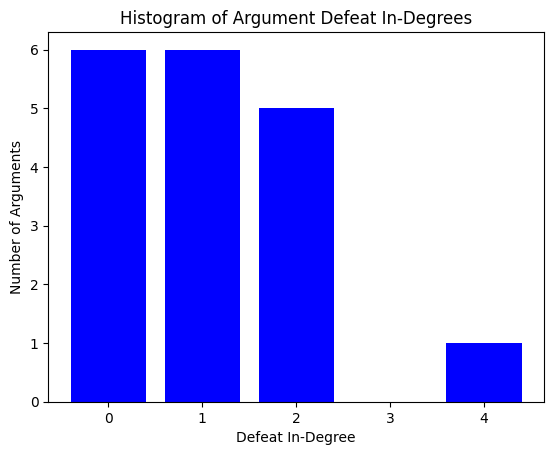

In [23]:
import matplotlib.pyplot as plt

# Function to check if one argument defeats another based on conclusions
def defeats(arg1, arg2):
    # Simple model: arg1 defeats arg2 if arg1's conclusion contraposes arg2's conclusion
    return str(arg1.top_rule.conclusion.contrapositive()) == str(arg2.top_rule.conclusion)

# Calculate defeat in-degrees
defeat_in_degrees = {}
for arg in all_arguments:
    defeat_in_degrees[arg.name] = 0  # Initialize defeat counts

# Calculate defeats based on the simple model
for arg1 in all_arguments:
    for arg2 in all_arguments:
        if arg1 != arg2 and defeats(arg1, arg2):
            defeat_in_degrees[arg2.name] += 1

# Prepare data for histogram
defeat_counts = list(defeat_in_degrees.values())
max_defeat = max(defeat_counts) if defeat_counts else 0
frequency_distribution = [0] * (max_defeat + 1)
for count in defeat_counts:
    frequency_distribution[count] += 1

# Plotting the histogram
plt.bar(range(len(frequency_distribution)), frequency_distribution, color='blue')
plt.xlabel('Defeat In-Degree')
plt.ylabel('Number of Arguments')
plt.title('Histogram of Argument Defeat In-Degrees')
plt.show()


In [24]:
app = Flask(__name__, template_folder='.')

@app.route('/', methods=['GET', 'POST'])
def home():
    if request.method == 'POST':
        strict_rule_input = request.form['strict_rule_input']
        defeasible_rule_input = request.form['defeasible_rule_input']
        selected_principles = request.form.getlist('principles')
        
        # Setup preferences based on selected principles
        preferences = {principle: set() for principle in selected_principles}

        # Parse rules
        strict_rules = parse_rules(strict_rule_input)
        defeasible_rules = parse_rules(defeasible_rule_input)

        # Generate contrapositions for the strict rules
        contrapositions = []
        for rule in strict_rules:
            contrapositions.extend(rule.contrapositive_rules())
        for i, rule in enumerate(contrapositions, start=1):
            rule.name = f"rC{i}"

        # Combine all rules
        all_rules = strict_rules + defeasible_rules + contrapositions
        arguments = generate_arguments(all_rules)
        
        # Generate undercuts and rebuts
        undercuts = generate_all_undercut(arguments)
        rebuts = generate_all_rebuts(arguments)
        
        # Define attacks for burden-based ranking
        attacks = {arg.name: {reb[1].name for reb in rebuts if reb[0] == arg} for arg in arguments}

        
        # Generate defeats based on selected principles
        generate_successful_defeats(all_arguments, all_rebuts, principle, link)

         # Compute burden-based rankings
        rankings = compute_burden_based_ranking(all_arguments, all_rebuts)
        
        # Return the template with additional data
        return render_template('results.html', arguments=arguments, contrapositions=contrapositions, undercuts=undercuts, rebuts=rebuts, successful_defeats=successful_defeats, rankings=rankings)
    return render_template('index.html')

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1